In [59]:
import os
import pandas as pd
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as ticker
import datetime
#pd.show_versions(as_json=False)

threshold = 1000

In [60]:
# Load Data
def load_raw(fn):
    datapath = os.path.join('../csse_covid_19_data/csse_covid_19_time_series/', fn)

    #datapath = '../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    return raw

raw = load_raw('time_series_covid19_confirmed_global.csv')
raw_deaths = load_raw('time_series_covid19_deaths_global.csv')

raw


,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,0,0,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,0,0,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,0,0,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,0,0,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,0,0,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,Saint Pierre and Miquelon,France,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
260,NaN,South Sudan,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4
261,NaN,Western Sahara,0,0,0,0,0,0,0,0,...,4,4,6,6,6,6,6,6,6,6
262,NaN,Sao Tome and Principe,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4


In [61]:
# Shift all the series
def shift(df, threshold=1000):
    maxDate = max(df.index)    
    for c in df.columns:
        for i,a in enumerate(df[c]):        
            if i==0 and a>threshold:
                df[c]=df[c].shift(4) # hack to push out china
                break
            if a>=threshold:
                df[c]=df[c].shift(-i)            
                break
    df=df.reset_index(drop=True)
    #del df['China']
    return df


In [62]:
%matplotlib inline
from math import pow


def plotdataframe(df, logy=False, legend=True):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    for c,m in zip(df,markers):
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=2.5)
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(prop=font)

    return ax

def plotdataframe_point(df, logy=False, legend=True, legend_loc='best', title=None):
    plt.rcParams["figure.figsize"] = [10, 10]
    fig, ax = plt.subplots()
    markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
    lines = []
    legendcols = []
    maxX = max([max([x for c in df for (x,y) in zip(df.index,df[c]) if y>0])])
    #print(maxX)
    for c,m in zip(df,markers):
        pts = list([x for (x,y) in zip(df.index,df[c]) if y>0])
        ys = list([x for x in df[c] if x>0])
        if len(pts)<=1:
            continue
        legendcols.append(c)
        df[c].plot(logy=logy, marker=m, fontsize=12,ax=ax, linewidth=1, color='#999999')
        
        offset = (10,0)
        #print([pts[0],pts[-1]],[ys[0],ys[-1]])
        l,=ax.plot([pts[0],pts[-1]],[ys[0],ys[-1]], linewidth=2.5, marker=m)
        lines.append(l)
        #growth = round((pow(ys[-1]/ys[0],1.0/(pts[-1]-pts[0]))-1)*100)
        growth = round((pow(ys[-1]/ys[-8],1.0/(pts[-1]-pts[-8]))-1)*100)
        
        alignment = 'left'
        if pts[-1]>0.9*maxX:
            offset = (0,5)
            alignment = 'center'
        ax.annotate('{} ({}%)'.format(c,growth), xy=(pts[-1],ys[-1]), xytext=offset, textcoords='offset points', ha=alignment, size=12)
    
    if logy:
        ax.get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
    legend and ax.legend(lines,legendcols,prop=font, loc=legend_loc)

    title and ax.set_title(title, size=14)
    return ax

def save_figure(maxDate, filename):
    savedir = os.path.join('data',maxDate.strftime('%Y%m%d'))
    if not os.path.isdir(savedir):
        os.makedirs(savedir)
    plt.savefig(os.path.join(savedir,filename))


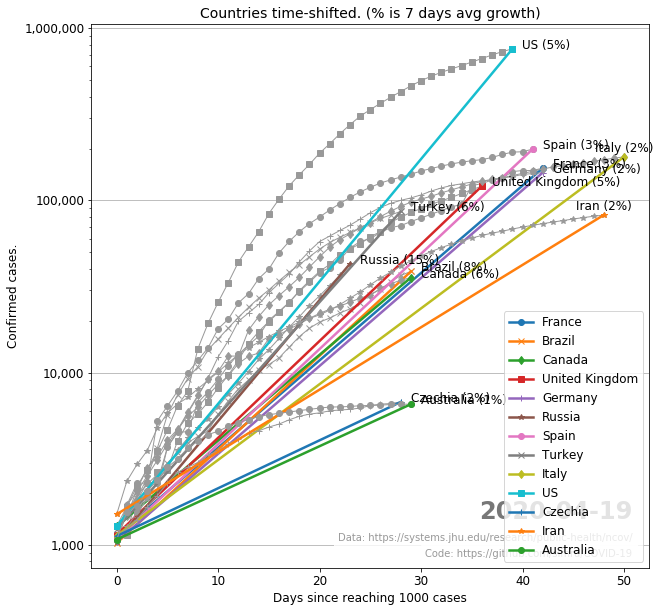

In [63]:
df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

threshold = 1000
del df['China']
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','Australia','Czechia']))
#print(columns)
#df = df[[c for c in df.columns if df[c].max()>12000 or c in ['Canada','US', 'Australia','Czechia']]]
df=df[columnsToSelect]
maxDate = max(df.index)
df = shift(df)

ax=plotdataframe_point(df, logy=True, title='Countries time-shifted. (% is 7 days avg growth)')
ax.set_xlabel("Days since reaching {} cases".format(threshold), size=12)
ax.set_ylabel("Confirmed cases." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'1_countryshift.png')


Removed:  ['Albania', 'Andorra', 'Antigua and Barbuda', 'Armenia', 'Austria', 'Bahamas', 'Bahrain', 'Barbados', 'Belarus', 'Belize', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei', 'Bulgaria', 'Burma', 'Cabo Verde', 'Central African Republic', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Fiji', 'Finland', 'Gabon', 'Gambia', 'Georgia', 'Grenada', 'Guinea-Bissau', 'Guyana', 'Holy See', 'Honduras', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Jamaica', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Latvia', 'Lebanon', 'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'MS Zaandam', 'Maldives', 'Malta', 'Mauritania', 'Mauritius', 'Moldova', 'Monaco', 'Mongolia', 'Montenegro', 'Namibia', 'New Zealand', 'Nicaragua', 'North Macedonia', 'Norway', 'Oman', 'Panama', 'Papua New Guinea', 'Paragua

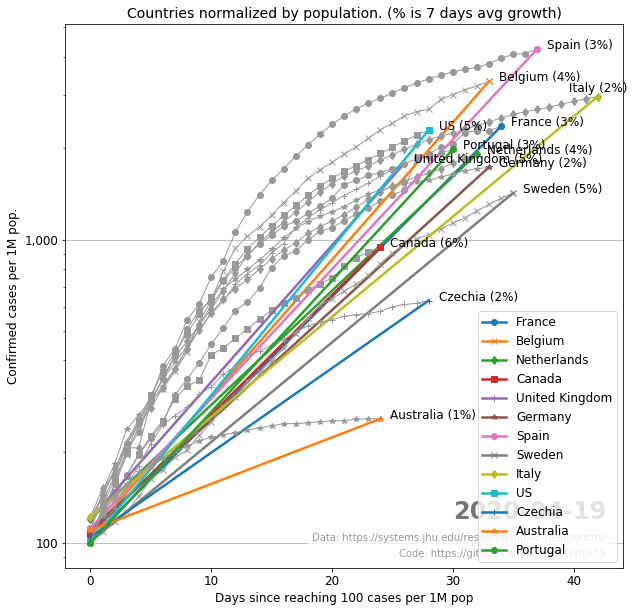

In [64]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

df=raw.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

columnsRemoved = [c for c in df.columns if c not in wpp or wpp[c]<10000]
columnsFiltered = [c for c in df.columns if c in wpp and wpp[c]>=10000]
df = df[columnsFiltered]
print("Removed: ",columnsRemoved)

#df = df[[c for c in df.columns if df[c].max()>10000 or c in ['Canada','US', 'Australia', 'Czechia']]]
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
#df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US', 'Australia', 'Czechia']]]
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','US','Australia','Czechia']))
df=df[columnsToSelect]


#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 100
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True, title="Countries normalized by population. (% is 7 days avg growth)")
ax.set_xlabel("Days since reaching {} cases per 1M pop".format(threshold), size=12)
ax.set_ylabel("Confirmed cases per 1M pop." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'2_countryshift_norm.png')

#wpp

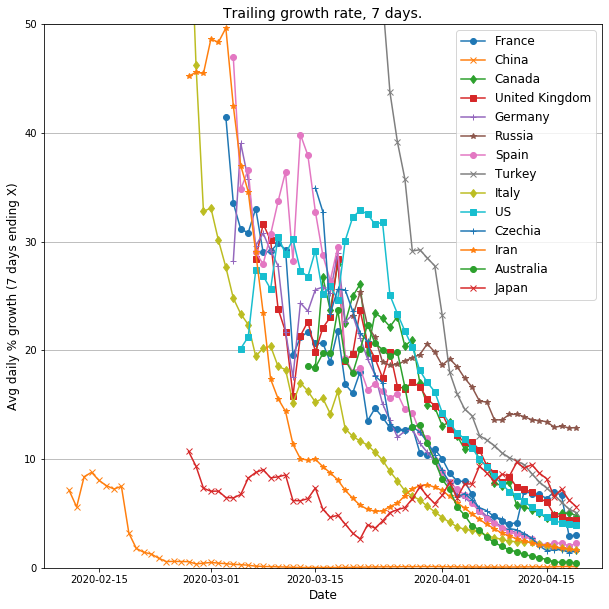

In [65]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>20000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']

columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['Canada','Australia','Japan','Czechia']))
df = df[columnsToSelect]

maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
for c,m in zip(df.columns,markers):
    growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    #if c=='France':
    #    print(list(df[c]))
    ax.plot(df.index[20:], growth[c], marker=m)

    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid(axis='y') 
#ax.yaxis.set_label_position("right")
ax.set_ylim([0,50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.set_title('Trailing growth rate, 7 days.', size=14)
ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'3_growth.png')

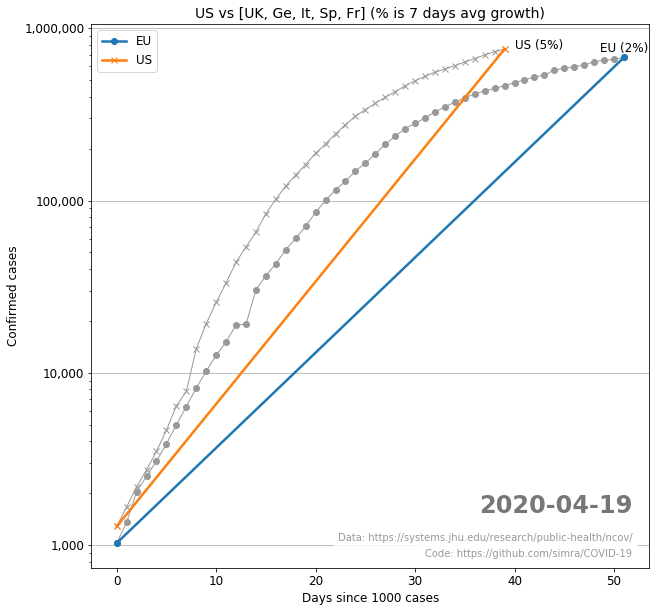

In [66]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
df = df[df.index.isin(['US','France','Germany','Italy','Spain', 'UK'])]
df = df.groupby(df.index=='US').sum()
df.index = ['US' if c else 'EU' for c in df.index]
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate = max(df.index)
threshold = 1000
df=shift(df,threshold=threshold)
ax=plotdataframe_point(df, logy=True)

ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.grid(axis='y')
ax.set_title('US vs [UK, Ge, It, Sp, Fr] (% is 7 days avg growth)', size=14)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '6_euus.png')

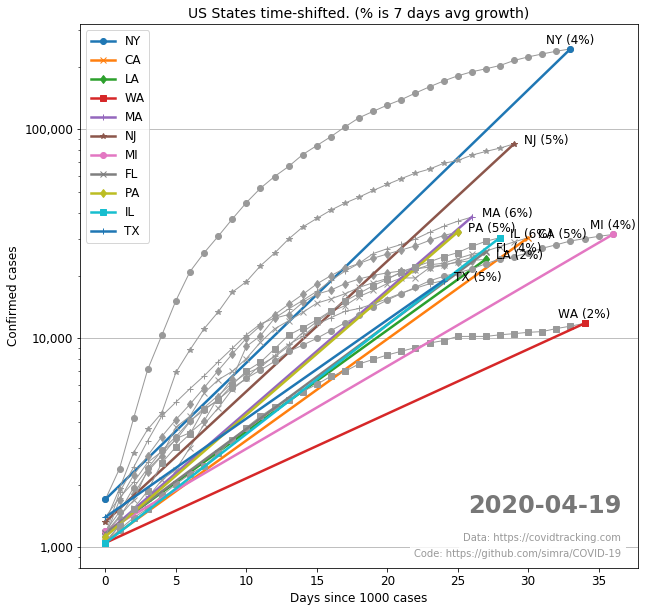

In [67]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
df = df.fillna(0)
columnsToSelect = list(set(list(sorted(df.columns, key=lambda c: max(df[c]), reverse=True))[:10]+['WA']))
#df = df[[c for c in df.columns if df[c].max()>5000 or c=='WA']]
df = df[columnsToSelect]

shift_threshold = 1000
df = shift(df, threshold=shift_threshold)

ax=plotdataframe_point(df, logy=True, title='US States time-shifted. (% is 7 days avg growth)')


ax.set_xlabel('Days since {} cases'.format(shift_threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.grid(axis='y')
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.05, 'Data: https://covidtracking.com', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'9_usstates.png')


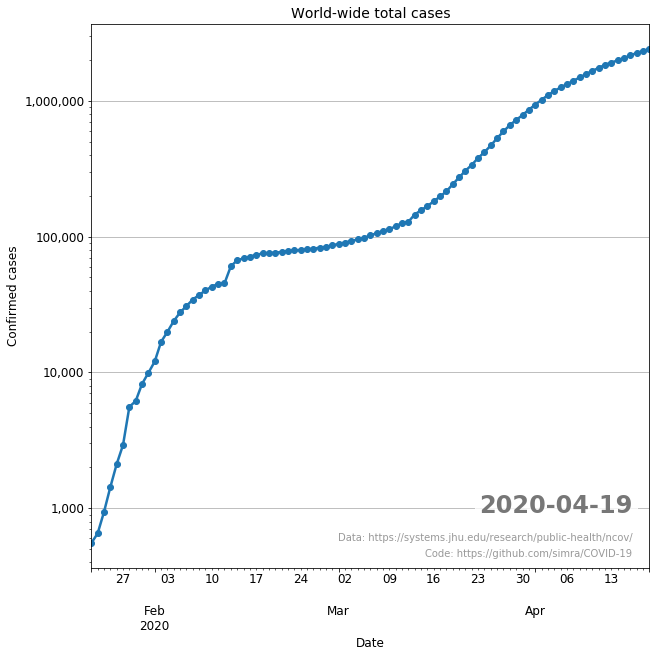

In [68]:
df=raw.groupby(lambda x: True).sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

#df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>4000)]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
df.index = ['World']
df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
maxDate = max(df.index)
#del df['Cruise Ship']
#df=shift(df)
df
ax=plotdataframe(df, logy=True, legend=False)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('Date', size=12)
ax.set_title('World-wide total cases', size=14)
ax.grid(axis='y')
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate,'7_world.png')

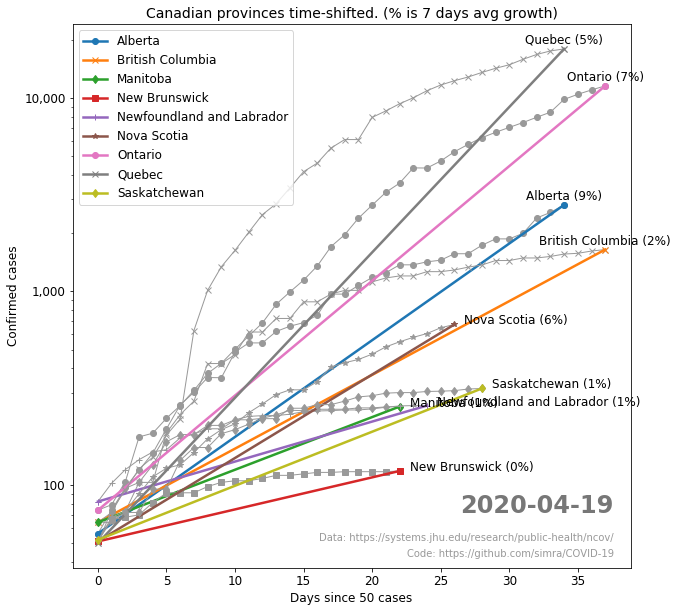

In [69]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)
df=shift(df,threshold)
df
ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Canadian provinces time-shifted. (% is 7 days avg growth)')
ax.set_xlabel('Days since {} cases'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '8_canada.png')

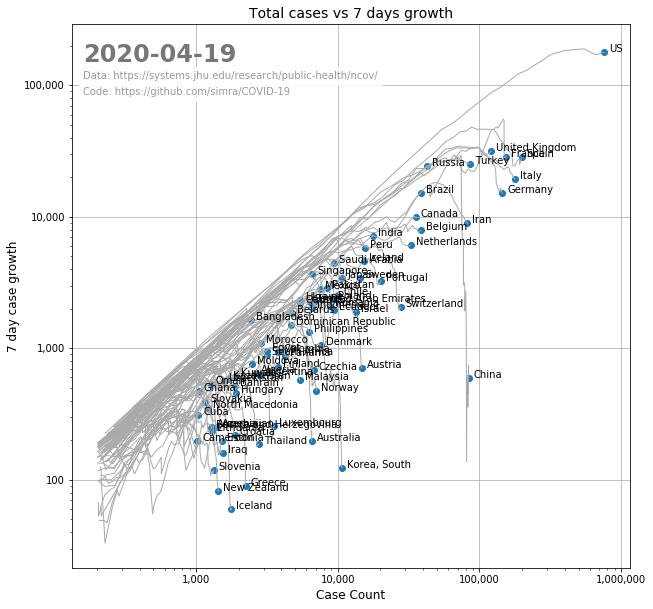

In [70]:
df=raw.groupby('Country/Region').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df = df[(df.index.isin(['Canada','Japan', 'Australia'])) | (df[last_date]>1000)]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
#del df['Cruise Ship']
maxDate=max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []
markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
start = 20
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if df[c][i]>200 else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('Total cases vs 7 days growth', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'10_countvsgrowth.png')

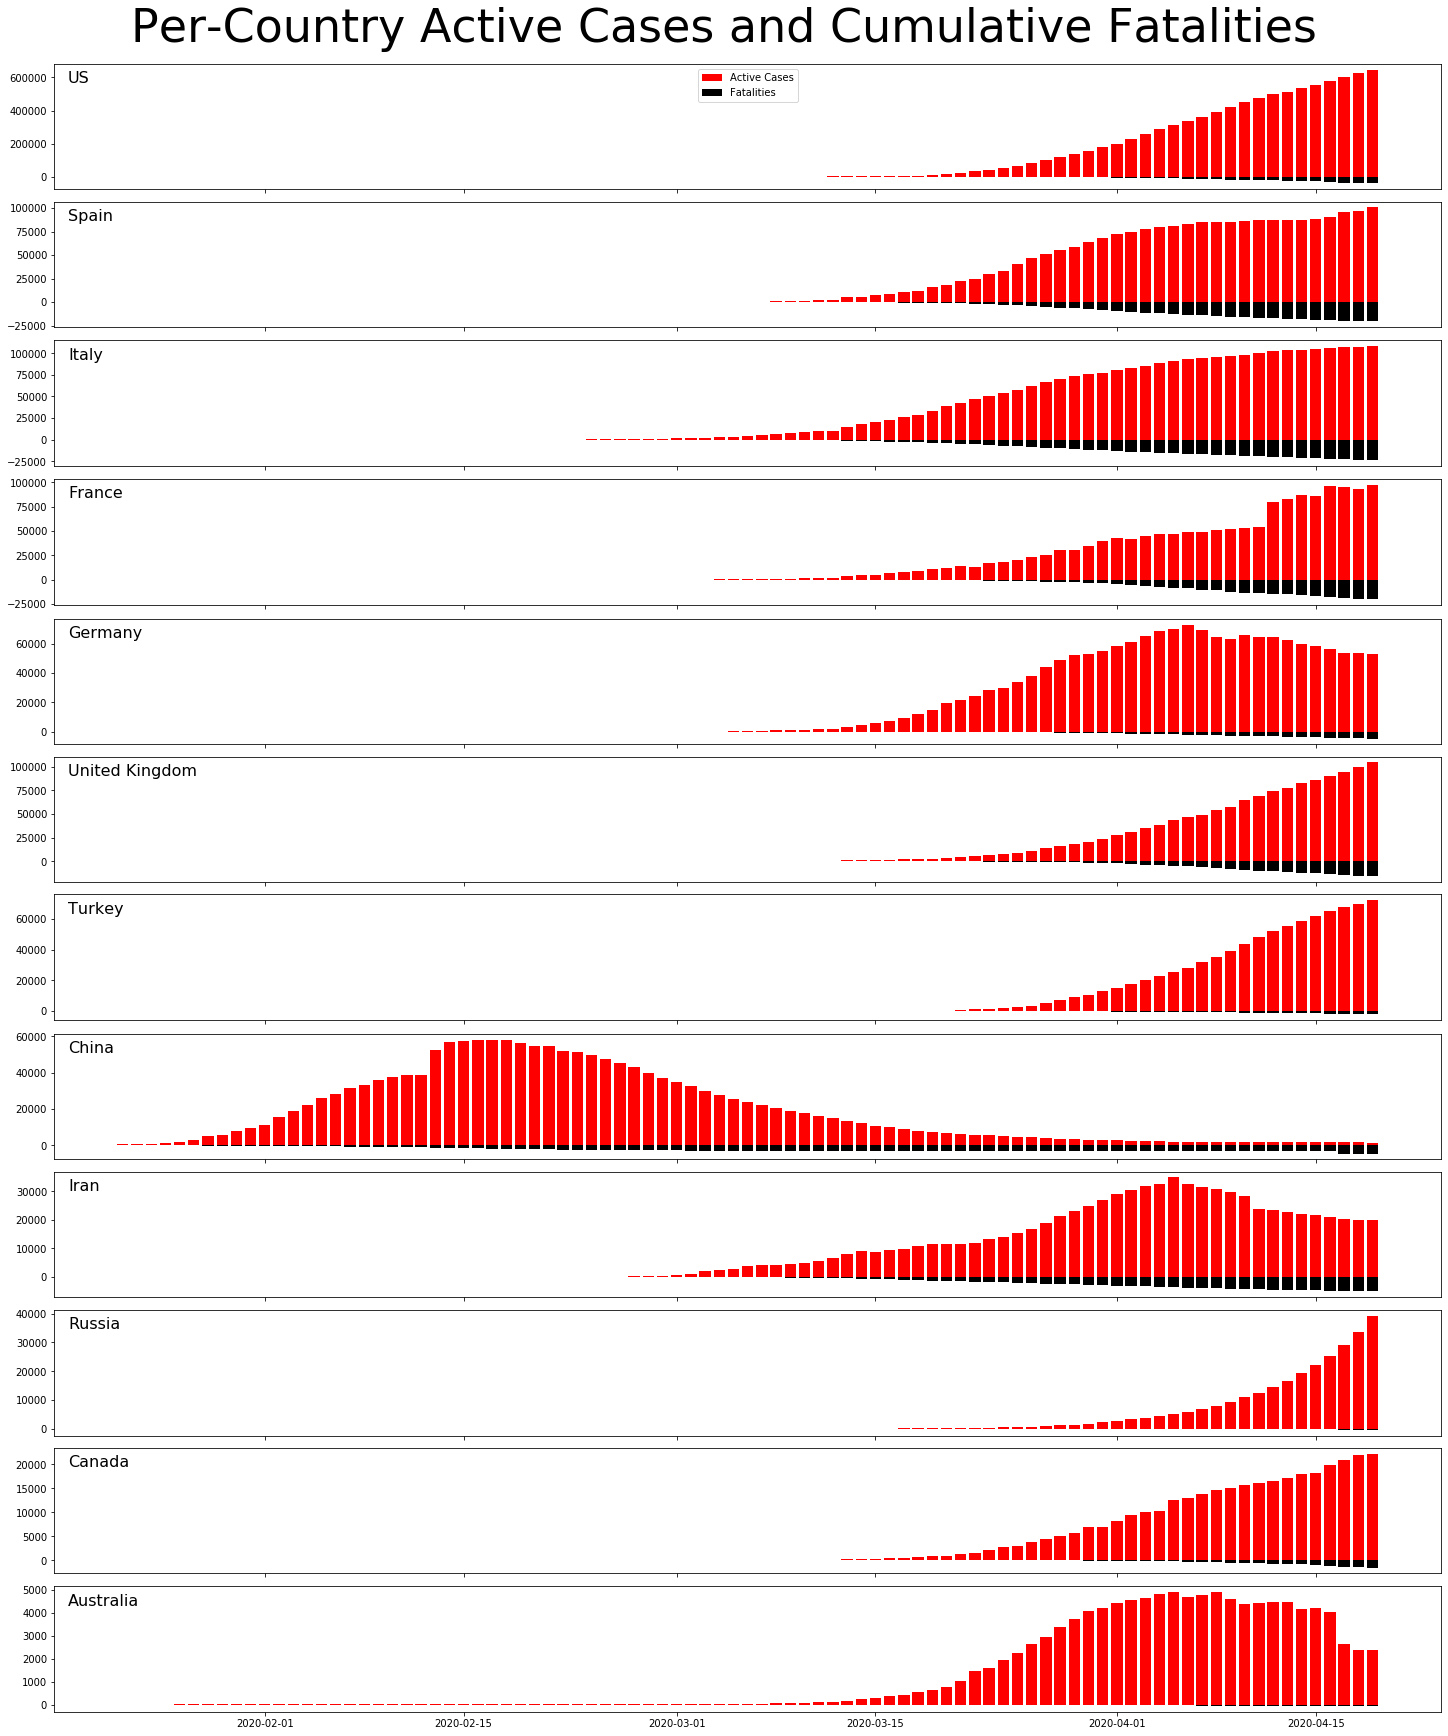

In [80]:


def prepData(datapath):
    raw = pd.read_csv(datapath)
    del raw['Lat']
    del raw['Long']
    raw= raw.replace('Mainland China','China')
    df=raw.groupby('Country/Region').sum()
    # 03/14: temporarily drop the last column
    #del df[df.columns[-1]]
    last_date = list(df.columns)[-1]

    #df = df[(df.index.isin(['Canada','Japan'])) | (df[last_date]>100)]

    df['Country/Region']=df.index
    df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
    df['date']=pd.to_datetime(df.index)

    df.index.name = None
    df=df.sort_values(by=['date'])
    df.set_index('date', inplace=True)
    df.columns = [c[1] for c in df.columns]
    return df

deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    fig.suptitle('Per-Country Active Cases and Cumulative Fatalities',size=46)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        active = []
        for (c,r,d) in zip(confirmed[country], recovered[country], deaths[country]):
            active.append(c-r-d) 
        #if country=='Canada':
        #print(active,confirmed[country])
        ax.bar(confirmed.index,active, color='red')
        rec = []
        for (r,d) in zip(recovered[country],deaths[country]):
            rec.append(r+d)        
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country]*(-1), color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16) 
        
        if i==0:
            ax.legend(['Active Cases','Fatalities'], loc='upper center')

countries = sorted(confirmed.columns, key=lambda x: confirmed[x][-1], reverse=True)[:10]
for c in ['Canada','Australia']:
    if c not in countries:
        countries+=[c]
#plotBars(['China','Canada','US','Italy','Singapore','Korea, South','Japan','Germany','France','Australia','United Kingdom','Spain'])
plotBars(countries)

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'5_barplots.png')

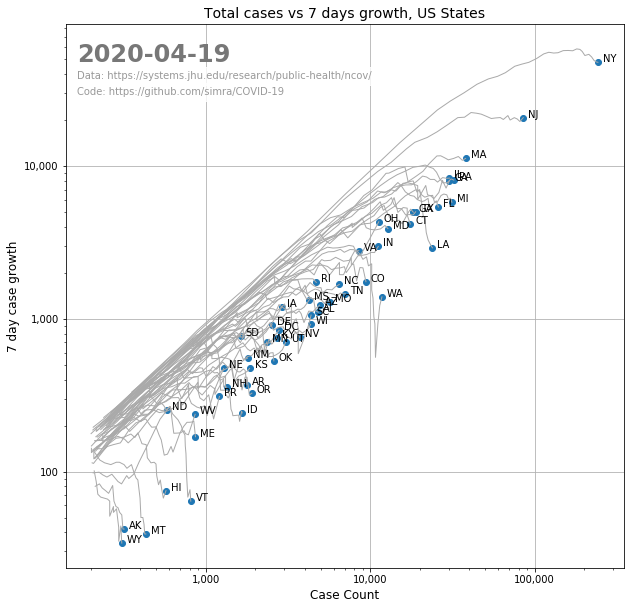

In [72]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
df = covidtracking.pivot(index='date',columns='state', values='positive')
#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)
plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
start = 7
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-6] if df[c][i]>200 else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
ax.set_title('Total cases vs 7 days growth, US States', size=14)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


save_figure(maxDate,'11_usstatesgrowth.png')

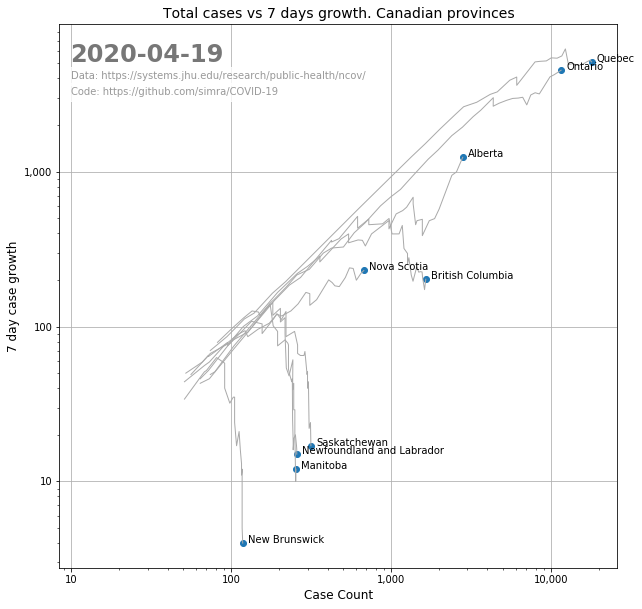

In [73]:
df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

maxDate = max(df.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
points = []

markers = [item for sublist in ['oxds+*']*ceil(len(df.columns)/5) for item in sublist]    
growth = {}
start = 7
for c,m in zip(df.columns,markers):
    #growth[c] = [(pow(df[c][i]/max(1.0,df[c][i-6]),1.0/7)-1)*100 if df[c][i]>200 else float('nan') for i in range(20,len(df[c]))]
    growth[c] = [df[c][i]-df[c][i-7] if df[c][i]>threshold else float('nan') for i in range(start,len(df[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(df[c][start:], growth[c], linewidth=1,color='#aaaaaa')
    points.append([df[c][-1],growth[c][-1],c])

ax.scatter([p[0] for p in points],[p[1] for p in points])   
for (x,y,txt) in points:
    ax.annotate(txt,(x,y), xytext=(5,0), textcoords='offset points')
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('Total cases vs 7 days growth. Canadian provinces', size=14)
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax.yaxis.set_label_position("right")
#ax.set_ylim([0,50])
ax.set_xlabel('Case Count', size=12)
ax.set_ylabel('7 day case growth', size=12)
#ax.legend(df.columns, prop=font)    
#plt.ylim((0,100))
ax.text(0.02, 0.93, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='left', weight=800)
ax.text(0.02, 0.90, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.02, 0.87, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='left', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))


save_figure(maxDate,'12_canadagrowth.png')


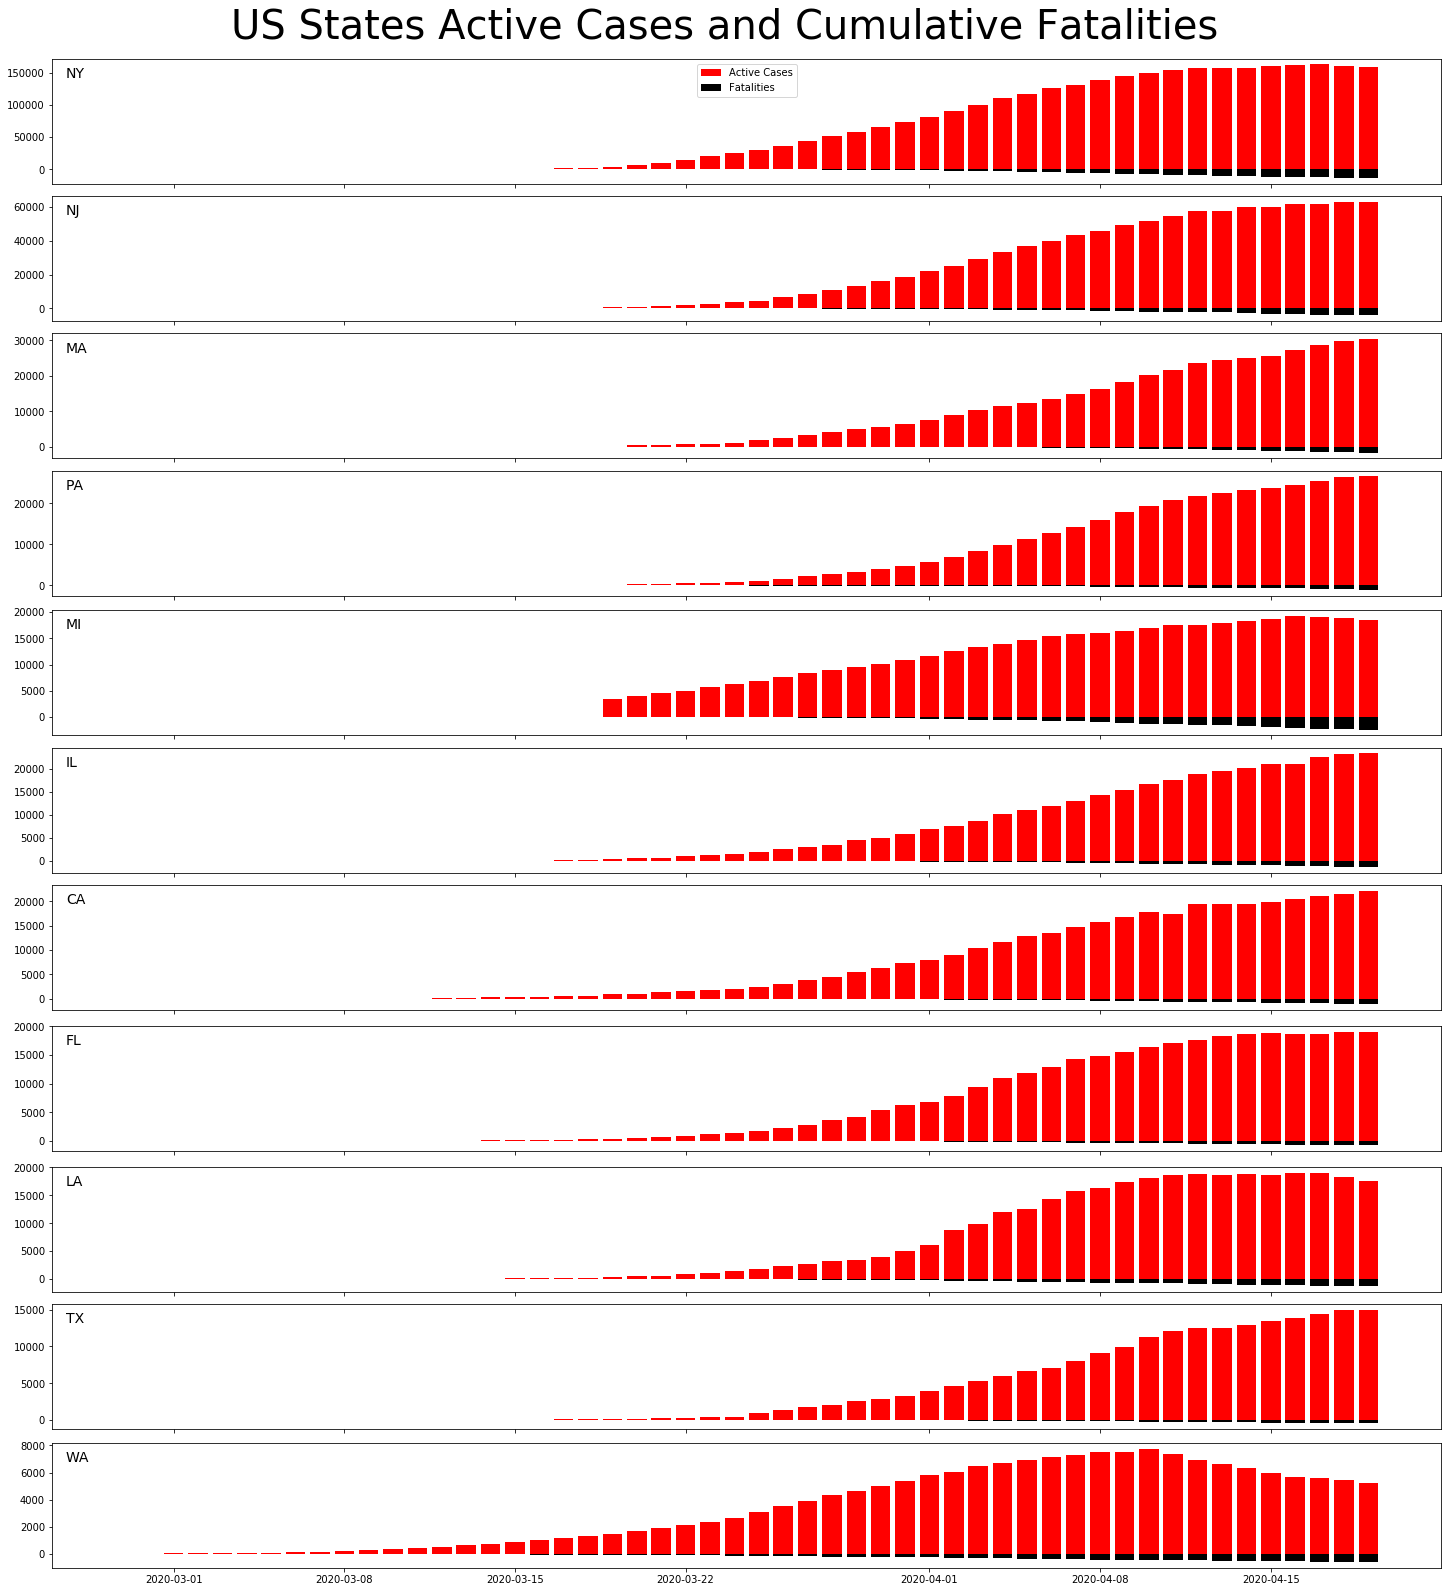

In [81]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
confirmed = covidtracking.pivot(index='date',columns='state', values='positive')
deaths = covidtracking.pivot(index='date',columns='state', values='death')
offset = 18

#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(df.index)


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        recovered = [0 if j-offset<0 else max(0,confirmed[country][j-offset]-deaths[country][j]) for j in range(0,len(confirmed[country]))]
        active = []
        for (c,r,d) in zip(confirmed[country], recovered, deaths[country]):
            active.append(c-r-d)
        ax.bar(confirmed.index,active, color='red')
        #ax.bar(confirmed.index,recovered, color='red')
        rec = []
        #for (r,d) in zip(recovered,deaths[country]):
        #    rec.append(r+d)
        #ax.bar(recovered.index,rec, color='green')
        ax.bar(deaths.index, deaths[country]*(-1), color='black')
        #ax.set_yscale('log')
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=14)
        fig.suptitle('US States Active Cases and Cumulative Fatalities',size=40)
        if i==0:
            ax.legend(['Active Cases','Fatalities'], loc='upper center')

statesToPlot = list(sorted(confirmed.columns, key=lambda c: max(confirmed[c].fillna(0)), reverse=True)[:10])
if 'WA' not in statesToPlot:
    statesToPlot += ['WA']
#plotBars(['WA','NY','CA','NJ','MA','LA','FL'])
plotBars(statesToPlot)

maxDate = confirmed.index[-1]
#print(maxDate)
save_figure(maxDate,'16_usbarplots.png')

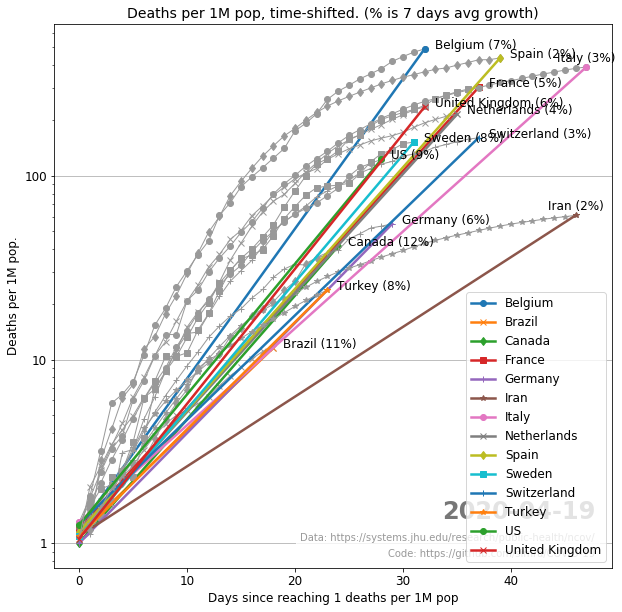

In [75]:
# Try normalizing by population
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv
wpp = pd.read_csv('../wpp/WPP2019_TotalPopulationBySex.csv')
wpp=wpp[(wpp['Time']==2020) & (wpp['Variant']=='Medium')]
wpp = dict(zip(wpp['Location'],wpp['PopTotal']))
wpp['Iran']=wpp['Iran (Islamic Republic of)']
wpp['US']=wpp['United States of America']
wpp['Korea, South']= wpp['Republic of Korea']
wpp['Russia'] = wpp['Russian Federation']

df=raw_deaths.groupby('Country/Region').sum()
last_date = list(df.columns)[-1]

df['Country/Region']=df.index
df=df.melt(id_vars='Country/Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Country/Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
    #del df['Cruise Ship']

    
df = df[[c for c in df.columns if df[c].max()>1000 or c in ['Canada','US']]] #, 'Australia', 'Czechia'
for c in df.columns:
    df[c] = df[c]*1000/wpp[c]
df = df[[c for c in df.columns if df[c].max()>10 or c in ['Canada','US']]] #, 'Australia', 'Czechia'

#plotdataframe(df, logy=True)
maxDate = max(df.index)
threshold = 1
df= shift(df,threshold=threshold)

ax=plotdataframe_point(df, logy=True, title='Deaths per 1M pop, time-shifted. (% is 7 days avg growth)')
ax.set_xlabel("Days since reaching {} deaths per 1M pop".format(threshold), size=12)
ax.set_ylabel("Deaths per 1M pop." , size=12)
ax.grid(axis='y')
ax.text(0.97, 0.09, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
save_figure(maxDate,'14_countryshift_norm-deaths.png')

#wpp

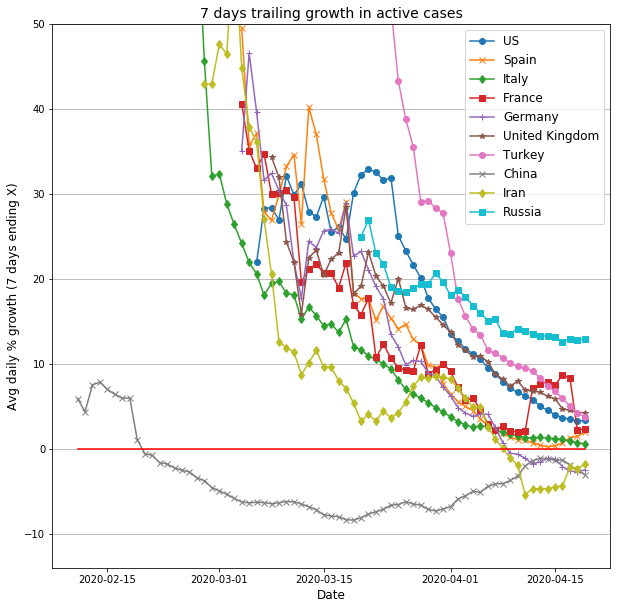

In [76]:
deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

columnsToSelect = sorted(confirmed.columns, key=lambda c: max(confirmed[c]), reverse=True)[:10]
#confirmed = confirmed[[c for c in confirmed.columns if max(confirmed[c])>10000]]
confirmed = confirmed[columnsToSelect]


def active(c):
    start = offset
    active = []
    for i in range(0,len(confirmed[c])):
        val = confirmed[c][i]-recovered[c][i]-deaths[c][i]
        if val<0: 
            print(c,confirmed[c][i], recovered[c][i], deaths[c][i])
        active.append(confirmed[c][i]-recovered[c][i]-deaths[c][i])        
    return active#del df['Cruise Ship']

maxDate=max(confirmed.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(confirmed.columns)/5) for item in sublist]    
for c,m in zip(confirmed.columns,markers):  
    active_cases = active(c)
    growth[c] = [(pow(active_cases[i]/max(1.0,active_cases[i-6]),1.0/7)-1)*100 if active_cases[i]>200 else float('nan') for i in range(20,len(confirmed[c]))]
    #growth[c] = [growth[c][i] if growth[c][i]<100 else float('nan') for i in range(len(growth[c]))]
    ax.plot(confirmed.index[20:], growth[c], marker=m)

ax.plot(confirmed.index[20:], [0]*len(confirmed.index[20:]),color='#ff0000')
    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)

ax.set_title('7 days trailing growth in active cases', size=14)
ax.grid(axis='y') 
#ax.yaxis.set_label_position("right")
lims=ax.get_ylim()
ax.set_ylim([lims[0],50])
ax.set_xlabel('Date', size=12)
ax.set_ylabel('Avg daily % growth (7 days ending X)', size=12)
ax.legend(confirmed.columns, prop=font)    
#plt.ylim((0,100))
save_figure(maxDate,'14_growthvsactive.png')

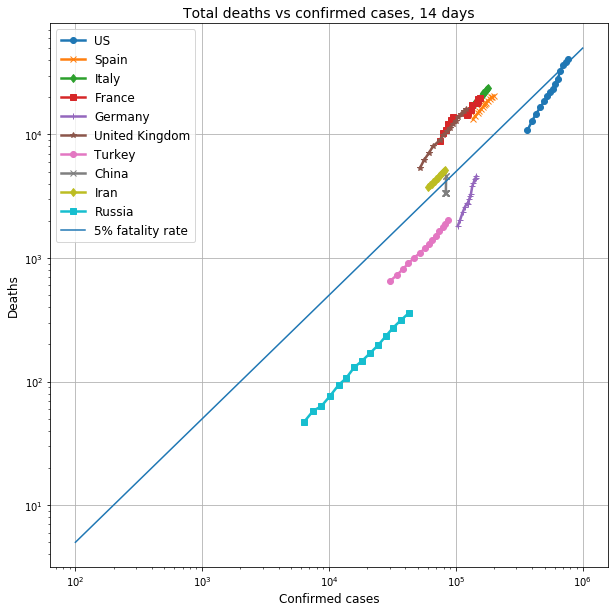

In [77]:
deaths = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
confirmed = prepData('../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

columnsToSelect = sorted(confirmed.columns, key=lambda c: max(confirmed[c]), reverse=True)[:10]
#confirmed = confirmed[[c for c in confirmed.columns if max(confirmed[c])>10000]]
confirmed = confirmed[columnsToSelect]
deaths = deaths[[c for c in confirmed.columns]]

maxDate=max(confirmed.index)

plt.rcParams["figure.figsize"] = [10, 10]
fig, ax = plt.subplots()
growth = {}
markers = [item for sublist in ['oxds+*']*ceil(len(confirmed.columns)/5) for item in sublist]    
for c,m in zip(confirmed.columns,markers):  
    ax.plot(confirmed[c][-14:],deaths[c][-14:], marker=m, linewidth=2.5)

ax.plot([100,1e6],[5,5e4])
    
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)


ax.grid() 
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Confirmed cases', size=12)
ax.set_ylabel('Deaths', size=12)
ax.set_title('Total deaths vs confirmed cases, 14 days', size=14)
ax.legend(list(confirmed.columns)+['5% fatality rate'], prop=font)    
save_figure(maxDate,'15_deathsvsconfirmed.png')

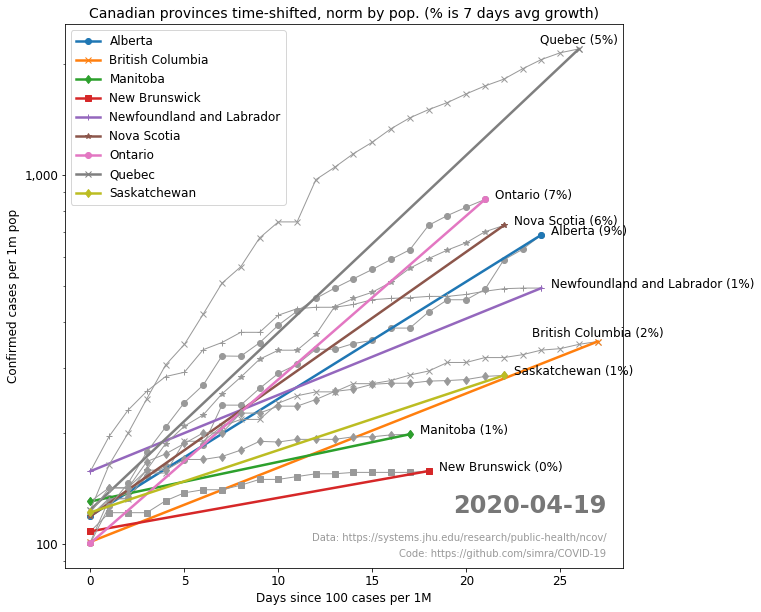

In [78]:
# 2016 census
canadapop = {
 'Ontario': 13448494,
 'Quebec': 8164361,
 'British Columbia': 4648055,
 'Alberta': 4067175,
 'Manitoba': 1278365,
 'Saskatchewan': 1098352,
 'Nova Scotia': 923598,
 'New Brunswick': 747101,
 'Newfoundland and Labrador': 519716,
 'Prince Edward Island': 142907,
 'Northwest Territories': 41786,
 'Nunavut': 35944,
 'Yukon': 35874

}

df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
threshold=50
df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Province/State']=df.index
df=df.melt(id_vars='Province/State',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province/State')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

for c in df.columns:
    df[c] = df[c]*1e6/canadapop[c]
        
threshold = 100
maxDate = max(df.index)
df=shift(df,threshold)
df
# TODO: change to log plot if these grow > 1
ax=plotdataframe_point(df, logy=True, legend_loc='upper left', title='Canadian provinces time-shifted, norm by pop. (% is 7 days avg growth)')
ax.set_xlabel('Days since {} cases per 1M'.format(threshold), size=12)
ax.set_ylabel('Confirmed cases per 1m pop', size=12)
ax.text(0.97, 0.1, maxDate.strftime('%Y-%m-%d'), transform=ax.transAxes, color='#777777', size=24, ha='right', weight=800)
ax.text(0.97, 0.05, 'Data: https://systems.jhu.edu/research/public-health/ncov/', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
ax.text(0.97, 0.02, 'Code: https://github.com/simra/COVID-19', transform=ax.transAxes, ha='right', size=10,
        color='#999999', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

save_figure(maxDate, '16_canada_normalized.png')

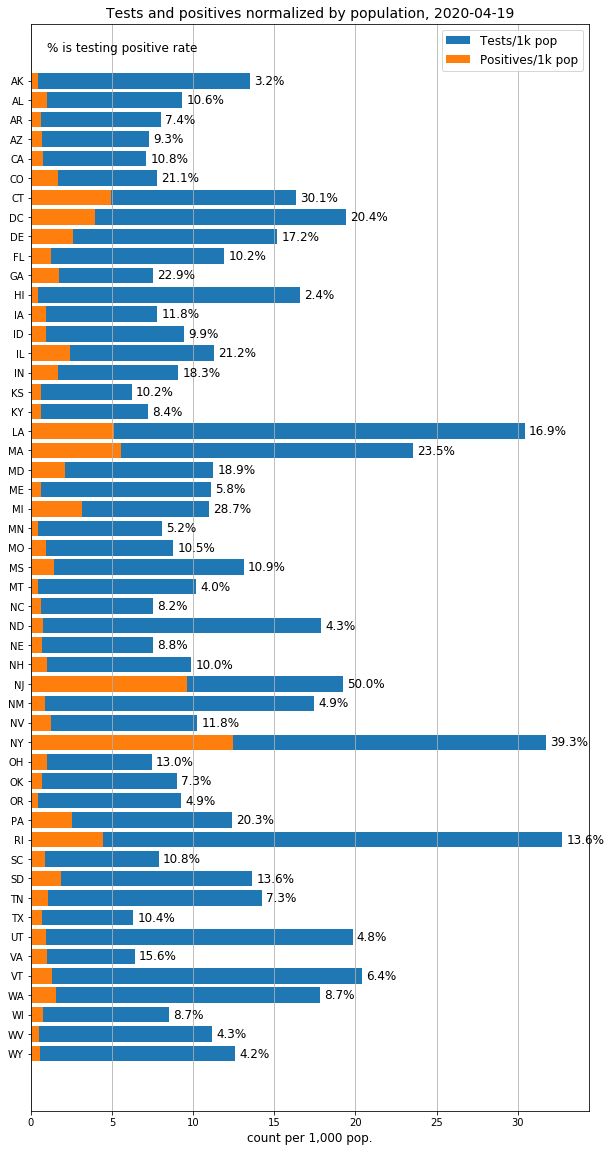

In [84]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
positives = covidtracking.pivot(index='date',columns='state', values='positive')
positives=positives.fillna(0)
negatives = covidtracking.pivot(index='date',columns='state', values='negative')
negatives=negatives.fillna(0)

statecodes = pd.read_csv('../expdev07/statecodes.tsv', sep='\t',names=['Abbrev','State'])
statecodes = dict(zip(statecodes['State'],statecodes['Abbrev']))

pop = pd.read_csv('../other3p/state_pop.txt', sep='\t', names=['State','Pop'])
pop = dict(zip([statecodes[c.replace('.','')] for c in pop['State']],pop['Pop']))
#icu
#print(pop,positives.columns)
cols = sorted([c for c in positives.columns if c in pop], reverse=True)
data = list(zip(cols, [max(positives[c])*1e3/pop[c] for c in cols], [max(positives[c]+negatives[c])*1e3/pop[c] for c in cols]))

plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
labels = [c for (c,_,_) in data]
ax.grid(b=True,axis='x')
ax.barh(labels, [x for (_,_,x) in data])
ax.barh(labels, [x for (_,x,_) in data])
for y,d in enumerate(data):
    (_,p,t) = d
    ax.text(t+0.25, y, '{:.1f}%'.format((p/t)*100),size=12,      ha='left', va='center')
ax.text(1,len(data)+0.5, '% is testing positive rate', size=12)
font = font_manager.FontProperties(family='sans-serif',
                                   weight='normal',
                                   style='normal', size=12)
#ax.title('Per state estimated active cases vs ICU beds.')
ax.legend(['Tests/1k pop','Positives/1k pop'], prop=font)
ax.set_title('Tests and positives normalized by population, {}'.format(maxDate.strftime('%Y-%m-%d')),size=14)
ax.set_xlabel('count per 1,000 pop.', size=12)
save_figure(maxDate,'17_tests.png')

In [85]:
# Positive rate = p(pos|sympt)*p(test|sympt)*p(sympt) + p(pos|asympt)*p(test|asympt)*p(asympt) 
# In states with highest positive rate, assume p(test|sympt) is ~1 and p(test|asympt) is ~0
data_aug = [(s,p,t,p/t) for (s,p,t) in data]
top_pos_sympt = [pp for (s, p, t,pp) in sorted(data_aug, key=lambda x: x[3], reverse=True)[:5]]
pos_sympt = (np.mean(top_pos_sympt,axis=0),np.std(top_pos_sympt, axis=0))
print(pos_sympt)

# States with lowest positive rate: assume these states are identifying all cases.
# Also assume the ratio of asump/(sympt+asymp) cases is the same everywhere. We can let this range from [0.1:0.5]
asymp_frac = np.arange(0.1,1.1,0.1)
print(asymp_frac)
(s,p,t,pp) = sorted(data_aug, key = lambda x: x[3])[0]
print(s,p,t,pp)
sympt_test = [p*(1-f)/pos_sympt[0] for f in asymp_frac]  # how many tests must be symptomatic
print(sympt_test)
asympt_test = [t - s for s in sympt_test] # tests must be asymptomatic
print(asympt_test) 
asympt_pos = [f*p for f in asymp_frac]
print(asympt_pos)
asympt_pos_rate = [f*p/(t-(p*(1-f)/pos_sympt[0])) for f in asymp_frac]

# take a state in the middle.
(s,p,t,pp) = sorted(data_aug, key = lambda x: x[3])[25]
# some 
    
# what fraction of asympt tests are positive? in this example it's 0 since we attributed all the positives to symptomatic tests
#plt.plot([x for x in range(0,int(t))], [pos_sympt[0]*x for x in range(0,int(t))])


(0.34312354557292574, 0.0935137213421185)
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
HI 0.405403878316684 16.576357184830268 0.02445675330208777
[1.0633589422602576, 0.9452079486757846, 0.8270569550913114, 0.7089059615068384, 0.5907549679223654, 0.4726039743378923, 0.35445298075341913, 0.23630198716894607, 0.11815099358447304, 0.0]
[15.51299824257001, 15.631149236154483, 15.749300229738957, 15.86745122332343, 15.985602216907903, 16.103753210492375, 16.22190420407685, 16.34005519766132, 16.458206191245797, 16.576357184830268]
[0.040540387831668405, 0.08108077566333681, 0.12162116349500522, 0.16216155132667362, 0.202701939158342, 0.2432423269900104, 0.2837827148216788, 0.32432310265334724, 0.3648634904850156, 0.405403878316684]


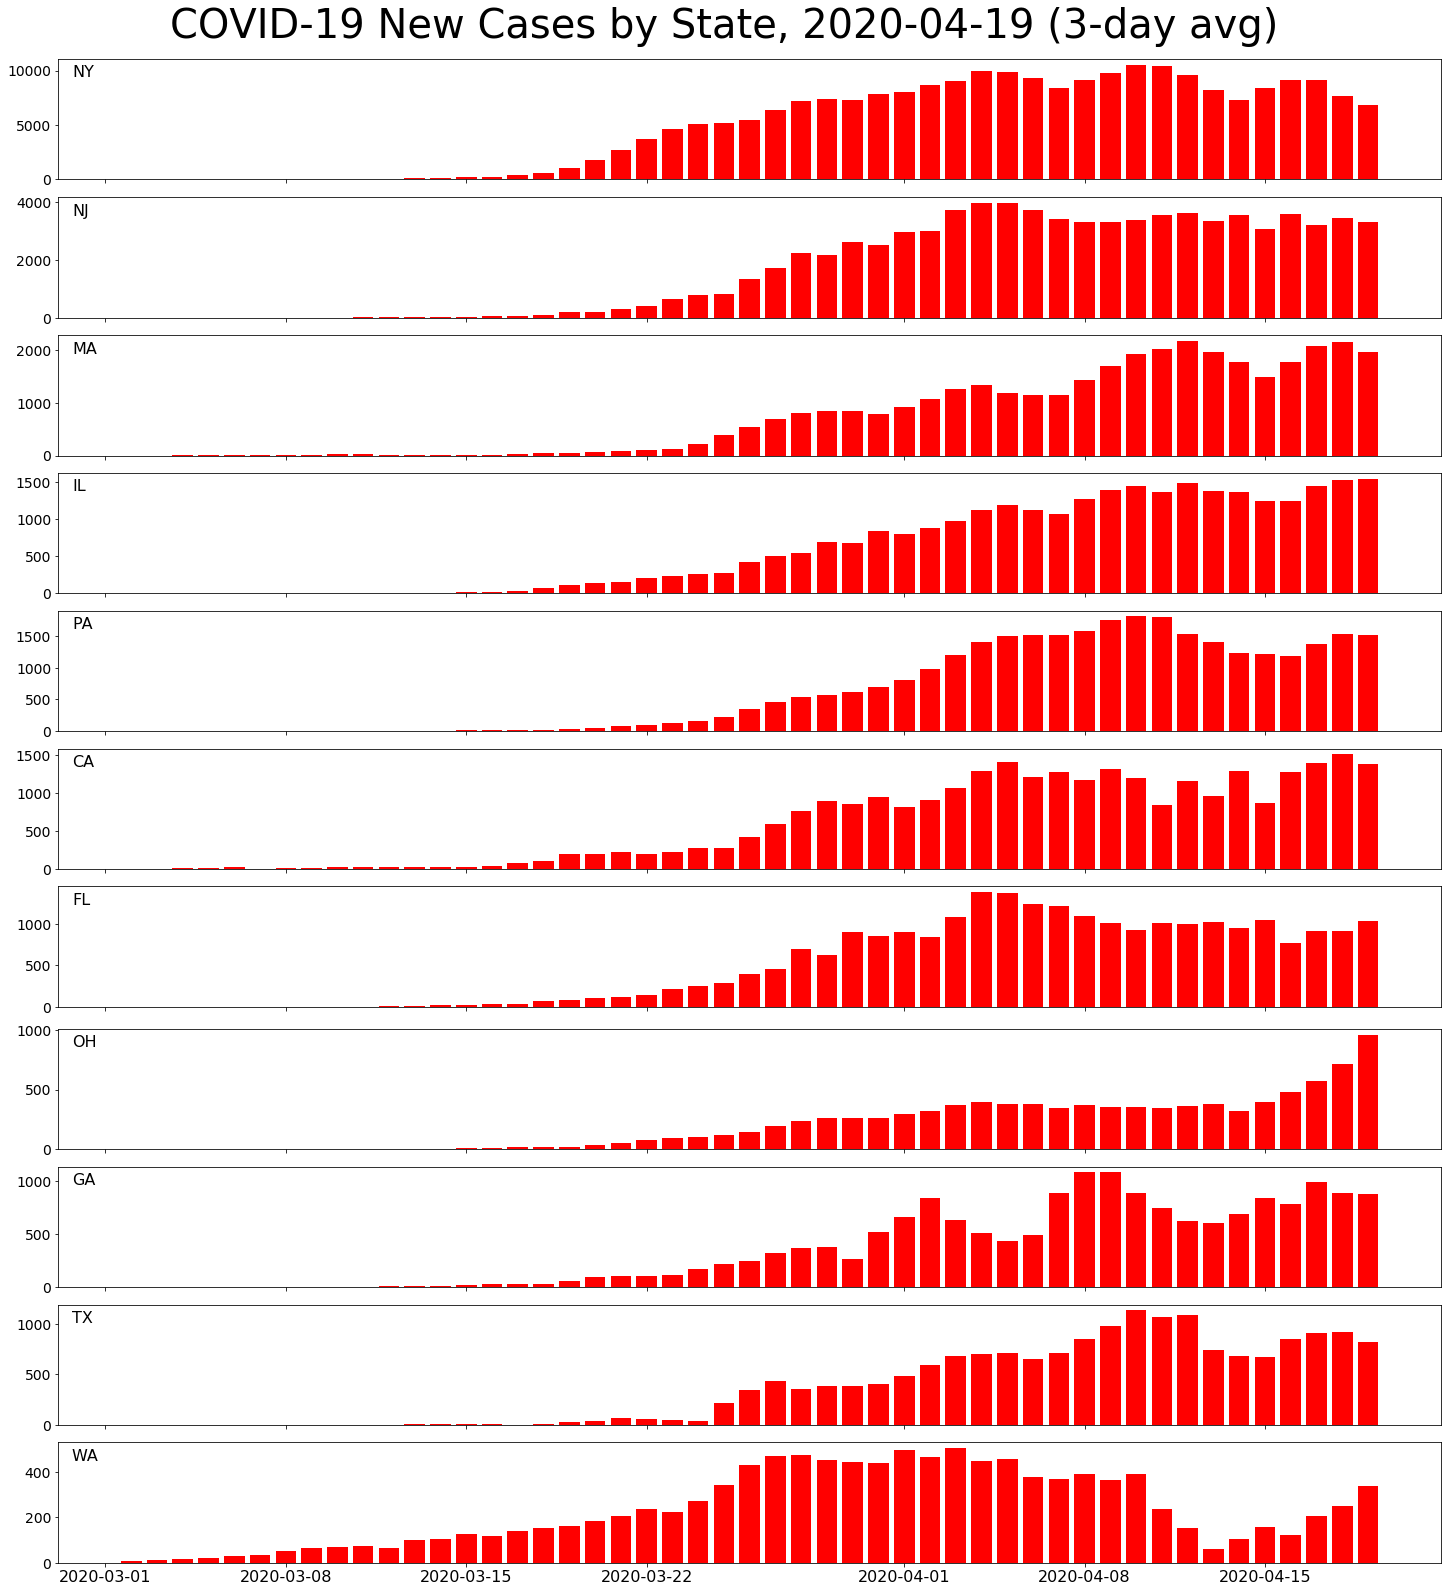

In [86]:
covidtracking = pd.read_csv('../other3p/covidtracking_daily.csv')
covidtracking['date'] = pd.to_datetime(covidtracking['date'],format="%Y%m%d")
maxDate = max(covidtracking['date'])
#increase = covidtracking.pivot(index='date',columns='state', values='positiveIncrease')
confirmed = covidtracking.pivot(index='date',columns='state', values='positive')

increase = {}
window = 3
dates = confirmed.index[window:]
for c in confirmed:
    cnf = confirmed[c].fillna(0)    
    increase[c]=[(cnf[j]-cnf[j-window])/window for j in range(window,len(cnf))]

#deaths = covidtracking.pivot(index='date',columns='state', values='death')
#offset = 18

#df = df[[c for c in df.columns if df[c].max()>1000]]

maxDate=max(confirmed.index)


def plotBars(countries):
    plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
    fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
    for (i,(country,ax)) in enumerate(zip(countries,axs)):
        ax.bar(dates,increase[country], color='red')
        #ax.bar(confirmed.index,recovered, color='red')
        
        ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=16)
        ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
        ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    fig.suptitle('COVID-19 New Cases by State, {} ({}-day avg)'.format(maxDate.strftime('%Y-%m-%d'), window),size=40)        

statesToPlot = sorted(increase, key=lambda c: increase[c][-1], reverse=True)[:10]+['WA']

#plotBars(['WA','NY','CA','NJ','MA','LA','FL'])
plotBars(statesToPlot)

#print(maxDate)
save_figure(maxDate,'18_newcases.png')

Index(['US', 'United Kingdom', 'Russia', 'Spain', 'Turkey', 'Italy', 'Brazil',
       'Germany', 'France', 'Canada', 'Australia', 'New Zealand'],
      dtype='object')


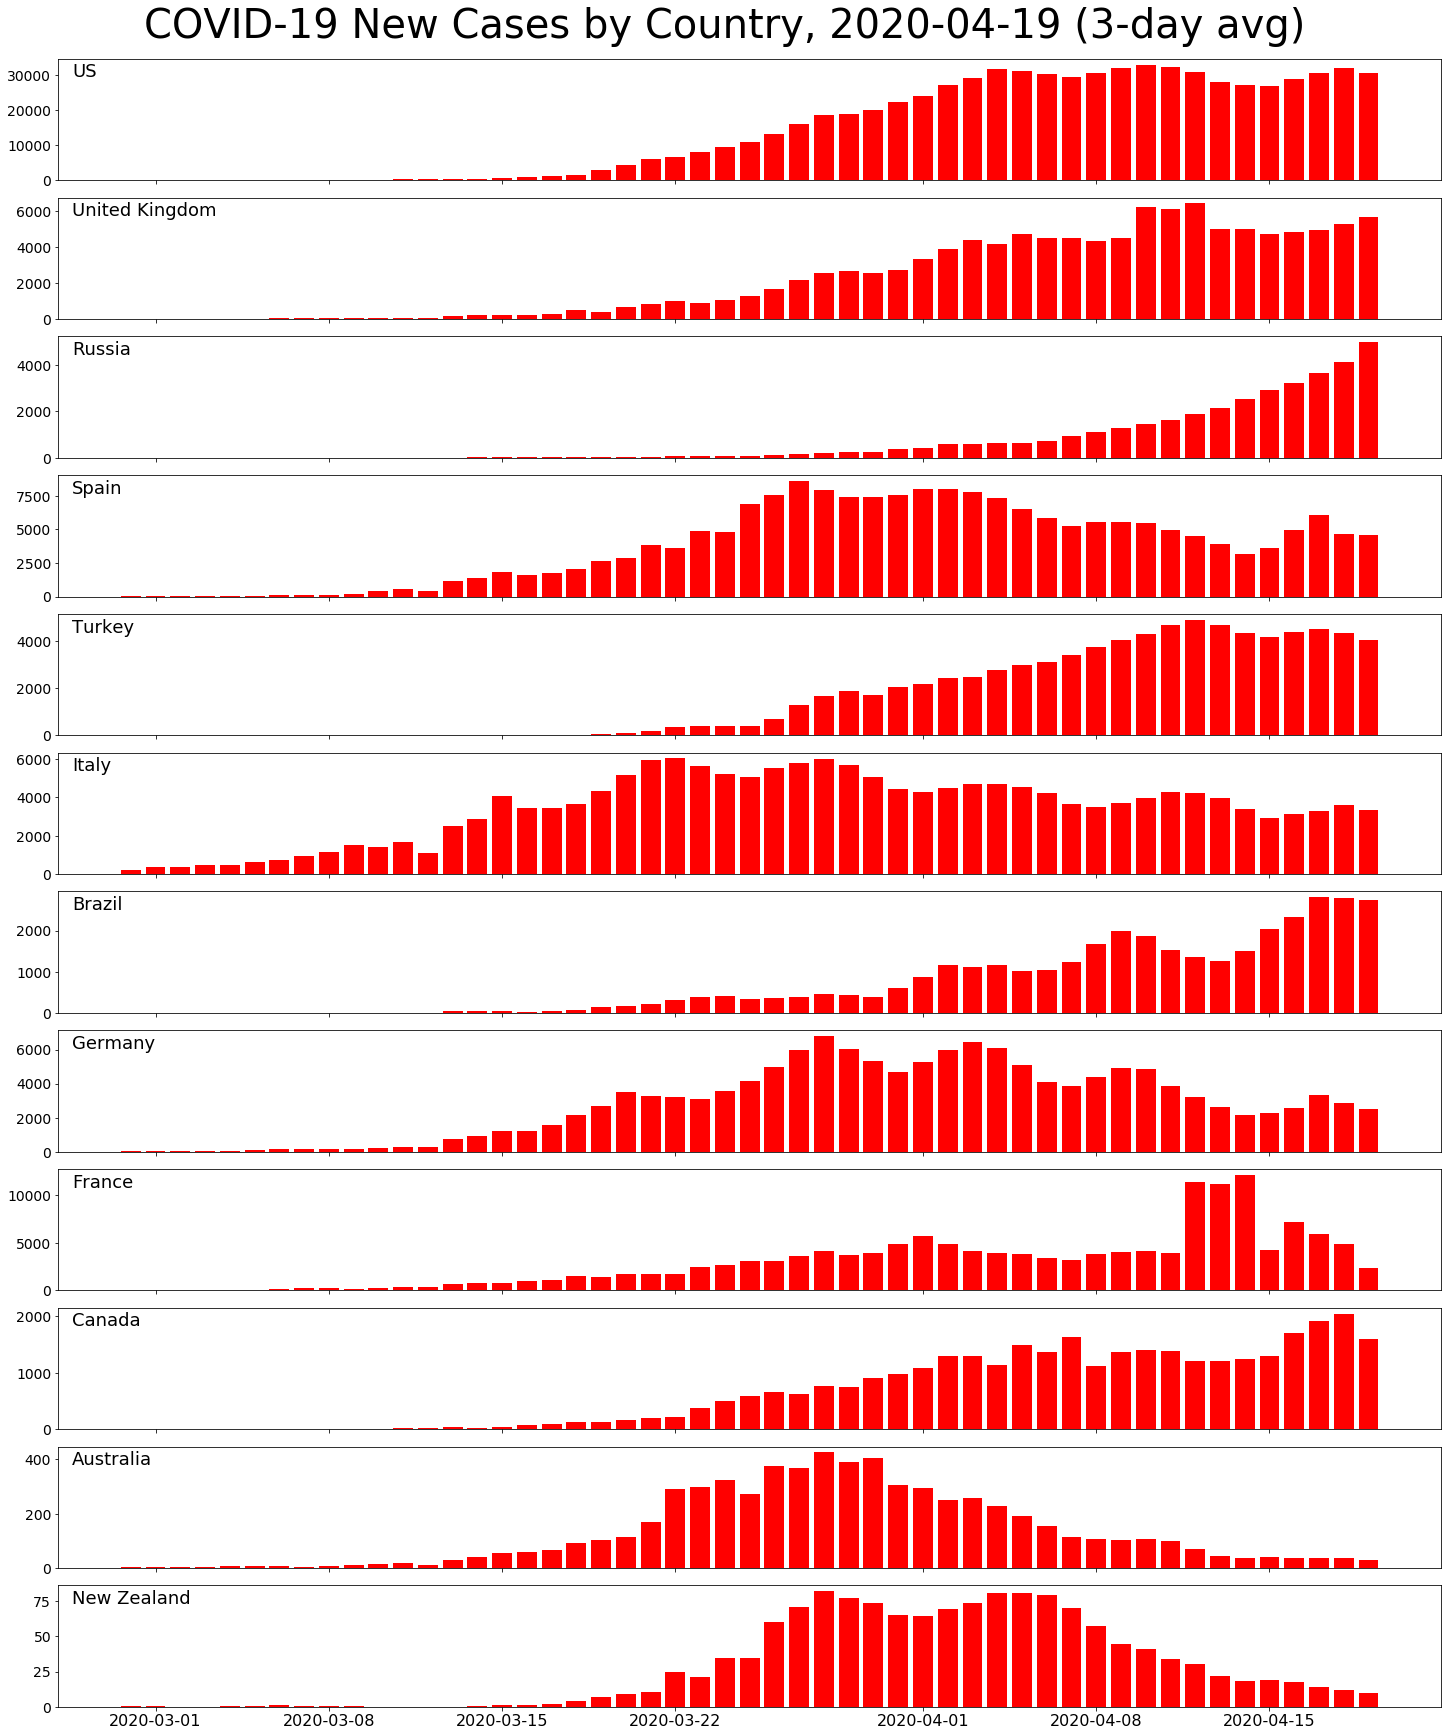

In [87]:
df = raw
#df['Region']= (df['Province/State'].fillna('')+', '+df['Country/Region']).apply(lambda x: x if x[0]!=',' else x[2:])
df['Region'] = df['Country/Region']
#print(df['Region'])
df=df.groupby('Region').sum()

# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]
#threshold=50
#df = df[df[last_date]>threshold]
#df = df[df.index.isin(['US','France','Germany','Italy','Spain'])]
#df = df.groupby(df.index=='US').sum()
#df.index = ['World']

df['Region']=df.index
df=df.melt(id_vars='Region',var_name='date', value_name='Confirmed').pivot(index='date',columns='Region')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]

window = 3
for c in df.columns:
    df[c] = [0]*window+[(df[c][i]-df[c][i-window])/window for i in range(window,len(df[c]))]
    
df = df[[c for c in sorted(df.columns, key=lambda x: df[x][-1], reverse=True)[:10]+['Australia','New Zealand']]]
print(df.columns)
countries=df.columns
# Jan 22 is the start. So index from 38: for March 1 
offset = 38
dates=df.index[offset:]
maxDate = max(df.index)
plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
for (i,(country,ax)) in enumerate(zip(countries,axs)):
    ax.bar(dates,df[country][offset:], color='red')
    #ax.bar(confirmed.index,recovered, color='red')
    ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=18)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    
fig.suptitle('COVID-19 New Cases by Country, {} ({}-day avg)'.format(maxDate.strftime('%Y-%m-%d'),window),size=40)        
    

save_figure(maxDate,'19_newcases_country.png')

Index(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon'],
      dtype='object')


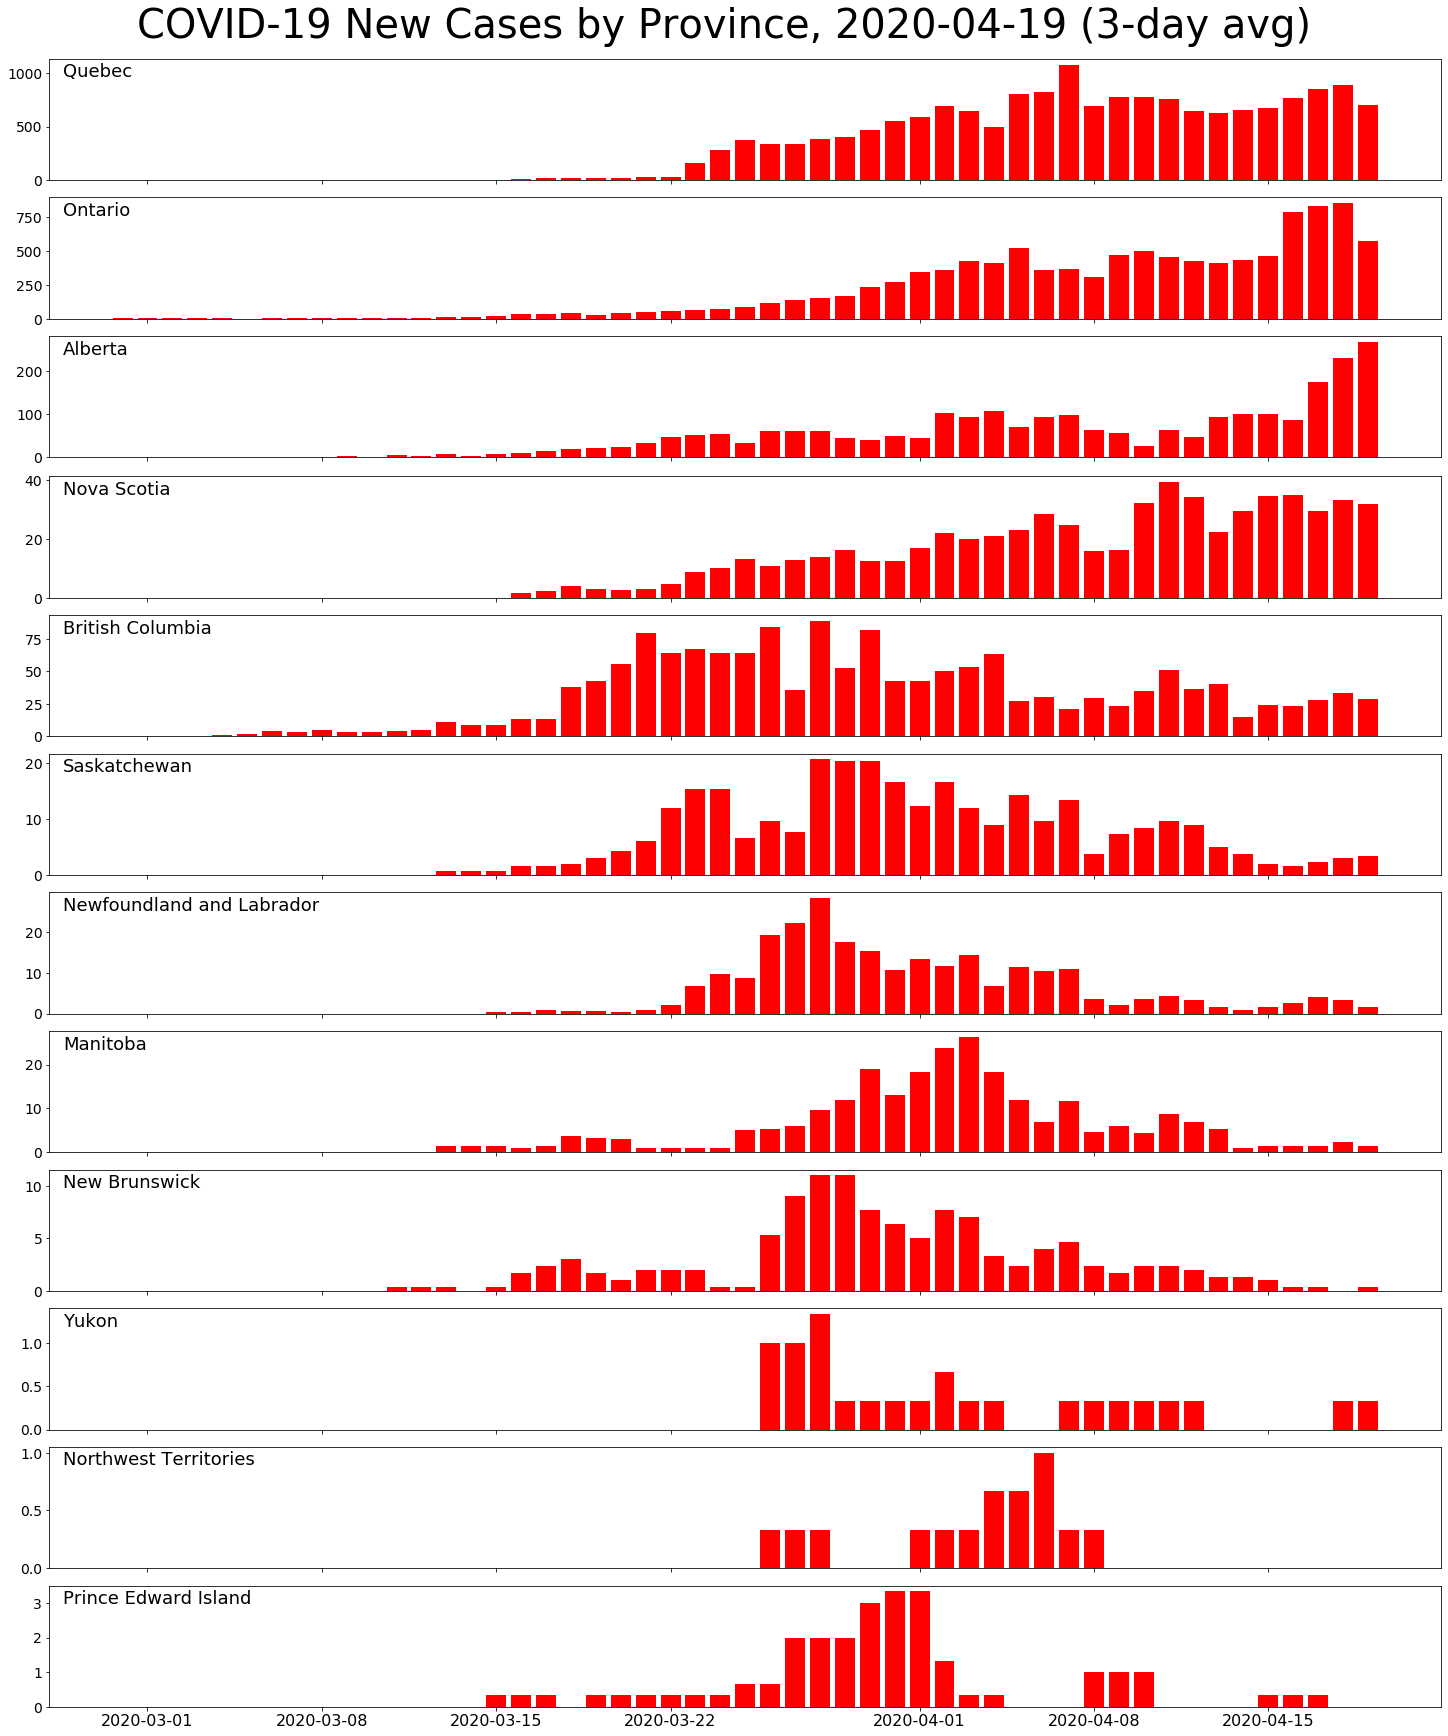

In [88]:

df = raw[raw['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df['Province']=df.index
df=df.melt(id_vars='Province',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

window = 3
for c in df.columns:
    df[c] = [0]*window+[(df[c][i]-df[c][i-window])/window for i in range(window,len(df[c]))]
    
#df = df[[c for c in sorted(df.columns, key=lambda x: df[x][-1], reverse=True)[:10]+['Australia','New Zealand']]]
print(df.columns)
countries=sorted(df.columns, key=lambda x: df[x][-1], reverse=True)
# Jan 22 is the start. So index from 38: for March 1 
offset = 38
dates=df.index[offset:]
maxDate = max(df.index)
plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
for (i,(country,ax)) in enumerate(zip(countries,axs)):
    ax.bar(dates,df[country][offset:], color='red')
    #ax.bar(confirmed.index,recovered, color='red')
    ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=18)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    
fig.suptitle('COVID-19 New Cases by Province, {} ({}-day avg)'.format(maxDate.strftime('%Y-%m-%d'),window),size=40)        
    

save_figure(maxDate,'20_newcases_province.png')

Index(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia',
       'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon'],
      dtype='object')


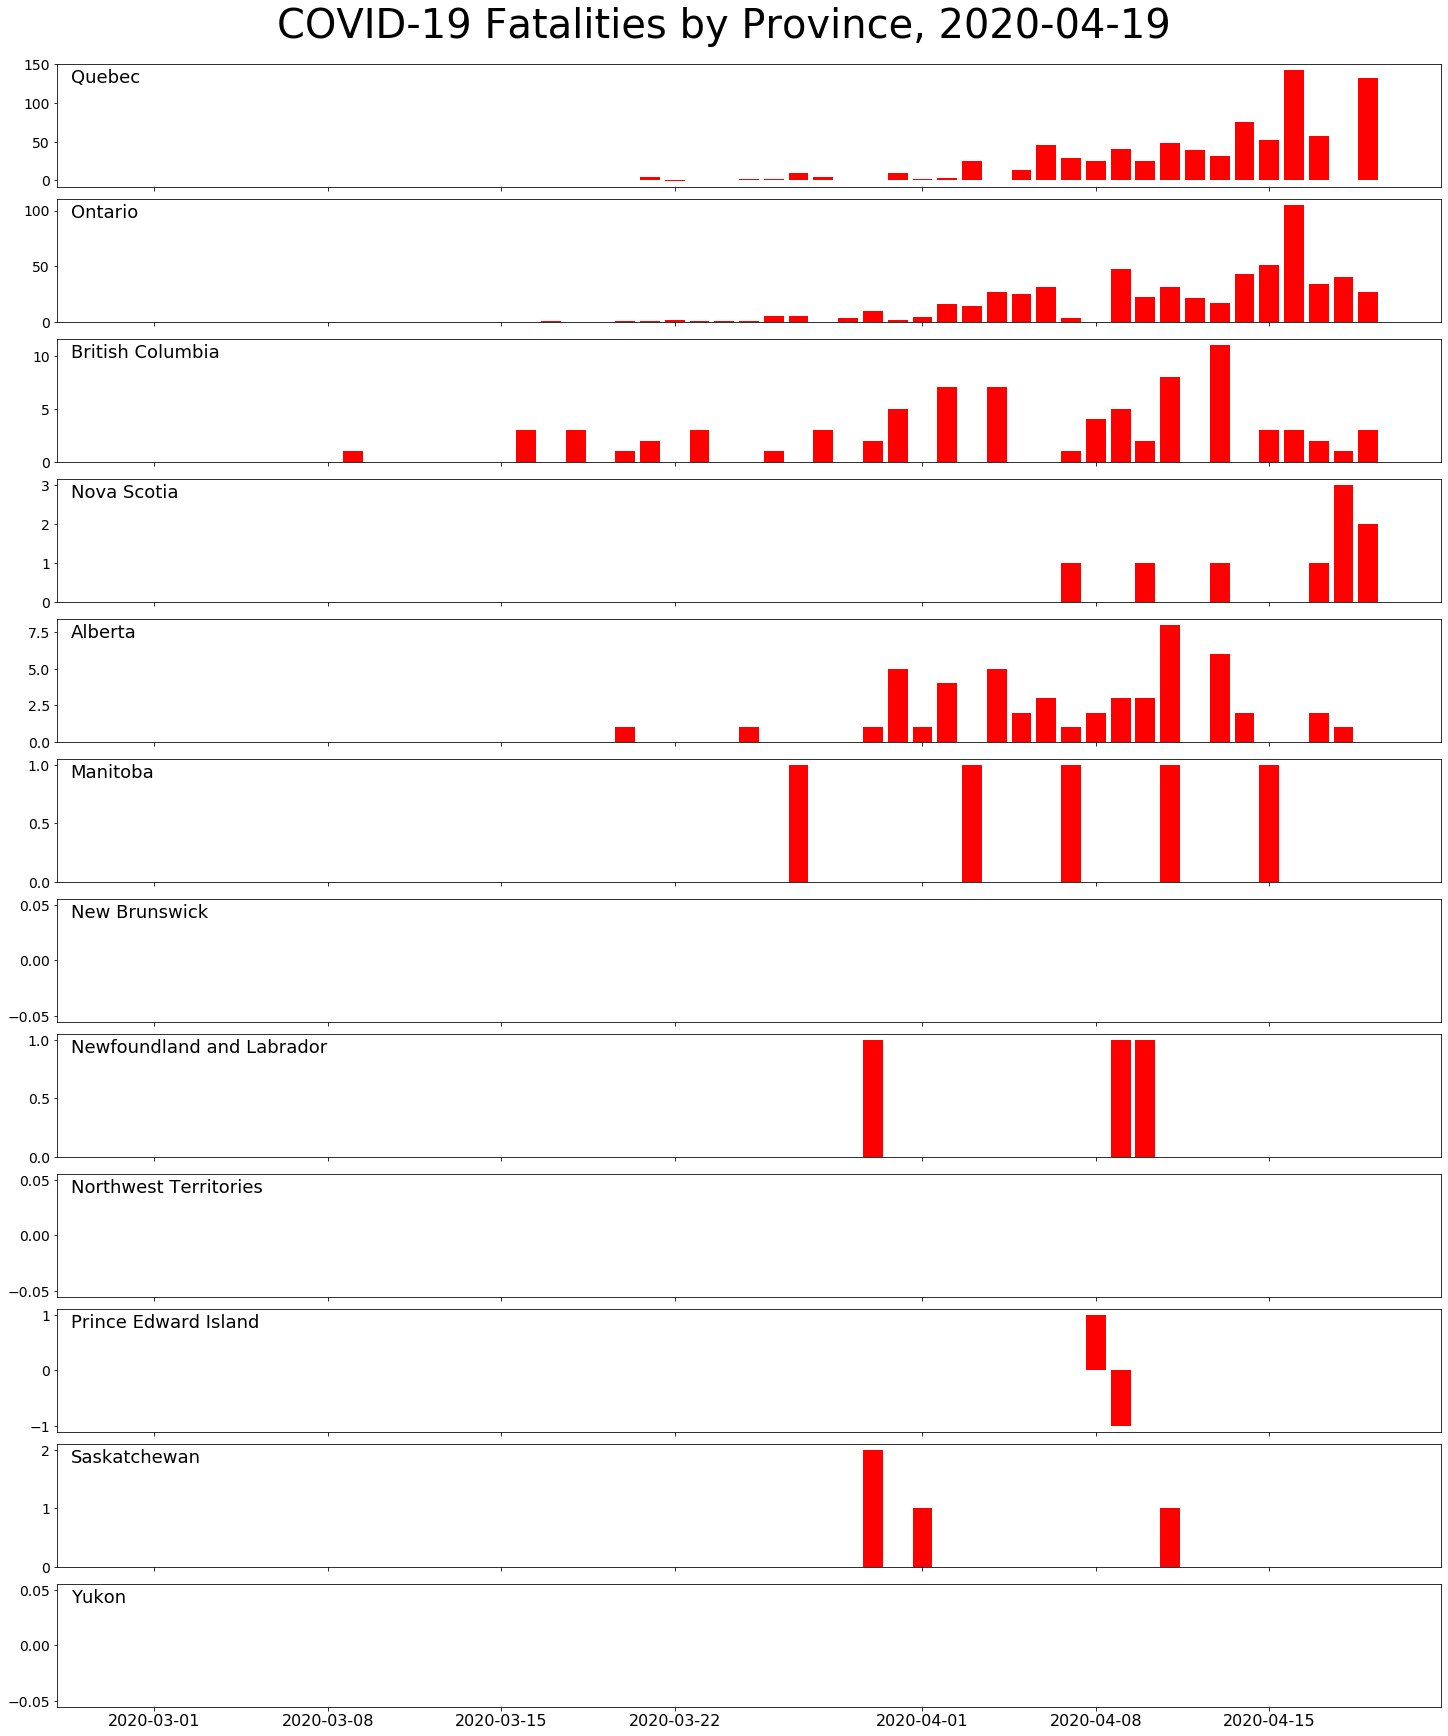

In [89]:

df = raw_deaths[raw_deaths['Country/Region']=='Canada']
df=df.groupby('Province/State').sum()
# 03/14: temporarily drop the last column
#del df[df.columns[-1]]
last_date = list(df.columns)[-1]

df['Province']=df.index
df=df.melt(id_vars='Province',var_name='date', value_name='Confirmed').pivot(index='date',columns='Province')
df['date']=pd.to_datetime(df.index)

df.index.name = None
df=df.sort_values(by=['date'])
df.set_index('date', inplace=True)
df.columns = [c[1] for c in df.columns]
for c in ['Recovered', 'Diamond Princess', 'Grand Princess']:
    if c in df:
        del df[c] 

window = 1
for c in df.columns:
    df[c] = [0]*window+[(df[c][i]-df[c][i-window])/window for i in range(window,len(df[c]))]
    
#df = df[[c for c in sorted(df.columns, key=lambda x: df[x][-1], reverse=True)[:10]+['Australia','New Zealand']]]
print(df.columns)
countries=sorted(df.columns, key=lambda x: df[x][-1], reverse=True)
# Jan 22 is the start. So index from 38: for March 1 
offset = 38
dates=df.index[offset:]
maxDate = max(df.index)
plt.rcParams["figure.figsize"] = [20, 2*len(countries)]
fig, axs = plt.subplots(len(countries),1, sharex=True,constrained_layout=True)
for (i,(country,ax)) in enumerate(zip(countries,axs)):
    ax.bar(dates,df[country][offset:], color='red')
    #ax.bar(confirmed.index,recovered, color='red')
    ax.text(0.01,0.85,country, transform=ax.transAxes, ha='left', size=18)
    ax.tick_params(axis = 'x', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'y', which = 'major', labelsize = 14)
    
fig.suptitle('COVID-19 Fatalities by Province, {}'.format(maxDate.strftime('%Y-%m-%d')),size=40)        
    

save_figure(maxDate,'21_fatalities_province.png')